              ------- MADRS 48h prediction --------

In [ ]:
Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import mean_squared_error

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

import math

In [3]:
# hyperparameters

step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 2880
learning_rate = 0.0001

Function for creating the segments and corresponding labels for MADRS prediction
 - it will read scores.csv (with all the demographics etc), and generates:
     -> one list of time sliced sequences
     -> one list of the corresponding participants' labels (madrs scores)

In [4]:
def segments_and_labels(dataset_dir, segment_length, step):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)

    segments = []
    labels = []

    for person in scores['number']:
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        for i in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[i : i + segment_length]
            
            segments.append([segment])
            labels.append(p['madrs2'].values[0])

    segments = np.asarray(segments)
    segments = segments.reshape(-1, segment_length, 1)

    input_shape = segments.shape[1]
    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    labels = np.asarray(labels).astype('float32')

    return segments, labels, input_shape

print(segments_and_labels(data_dir,segment_length,step))

(array([[  0., 143.,   0., ..., 809., 948., 712.],
       [306., 286.,  12., ...,  21.,  18.,  76.],
       [  0.,   0.,  21., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), array([19., 19., 19., ...,  0.,  0.,  0.], dtype=float32), 2880)


Splitting dataset, later I will add a validation set as well

In [5]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(18864, 2880)

(4717, 2880)

(18864,)

(4717,)


In [ ]:
Normalization

In [6]:
sc = MinMaxScaler(feature_range = (0,1))
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
y_test_scaled = sc.fit_transform(y_test.reshape(-1,1))

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

(18864, 2880)

(4717, 2880)

(18864, 1)

(4717, 1)


Reshaping, otherwise it won't fit in the LSTM model

In [7]:
X_train_scaled_res = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

y_train_scaled_res = np.reshape(y_train_scaled, (y_train_scaled.shape[0], y_train_scaled.shape[1], 1))

X_test_scaled_res = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_scaled_res = np.reshape(y_test_scaled, (y_test_scaled.shape[0], y_test_scaled.shape[1], 1))

print(X_train_scaled_res.shape)
print()
print(y_train_scaled_res.shape)
print()
print(X_test_scaled_res.shape)
print()
print(y_test_scaled_res.shape)

(18864, 2880, 1)

(18864, 1, 1)

(4717, 2880, 1)

(4717, 1, 1)


In [ ]:
Building LSTM model

In [33]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='lecun_normal', activation='linear'))
    model.compile(optimizer = optimizer, 
                  loss = 'mean_squared_error', 
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [34]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 2880, 30)          3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 2880, 30)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 2880, 30)          7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 2880, 30)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 2880, 30)          7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 2880, 30)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 30)               

Cross-validation + validation samples

In [9]:
train_data = X_train_scaled_res
train_targets = y_train_scaled_res
k = 3
num_val_samples = len(train_data) // k
num_epochs = 4
all_scores = [] # Should add the score of each run at the end of the loop
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model 
    model = build_model()
    # Train the model 
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_history = history.history['root_mean_squared_error']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_root_mean_squared_error']
    val_all_mae_histories.append(val_mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/4
786/786 [==============================] - 1957s 2s/step - loss: 0.1674 - root_mean_squared_error: 0.4090 - val_loss: 0.1229 - val_root_mean_squared_error: 0.3505
Epoch 2/4
786/786 [==============================] - 1965s 3s/step - loss: 0.1212 - root_mean_squared_error: 0.3480 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 3/4
786/786 [==============================] - 1953s 2s/step - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 0.1205 - val_root_mean_squared_error: 0.3471
Epoch 4/4
786/786 [==============================] - 1958s 2s/step - loss: 0.1224 - root_mean_squared_error: 0.3498 - val_loss: 0.1204 - val_root_mean_squared_error: 0.3470
processing fold # 1
Epoch 1/4
786/786 [==============================] - 1875s 2s/step - loss: 0.1426 - root_mean_squared_error: 0.3773 - val_loss: 0.1188 - val_root_mean_squared_error: 0.3446
Epoch 2/4
786/786 [==============================] - 1916s 2s/step - loss: 0.1208 - root_mean_s

In [25]:
print(np.mean([0.1204,0.1186,0.1215]))
print(val_mse)

0.12016666666666666
0.12147266417741776


Training and validation results of 24h segment LSTM MODEL

In [10]:
print("RMSE of fold 1, 2 and 3:\n")
print(all_scores)
print()
print("Mean RMSE of all folds:\n")
print(np.mean(all_scores))

RMSE of fold 1, 2 and 3:

[0.3470202386379242, 0.3444494903087616, 0.34852927923202515]

Mean RMSE of all folds:

0.3466663360595703


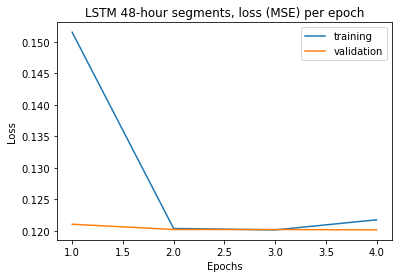

In [20]:
average_loss = [0.1515,0.1204,0.12016666666666669,0.12176666666666665]
average_val_loss = [0.12106666666666666,0.12023333333333334,0.12023333333333334,0.12016666666666666]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.title('LSTM 48-hour segments, loss (MSE) per epoch')
plt.show()

Average per-epoch RMSE for all folds

In [21]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
val_average_mae_history = [
    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]

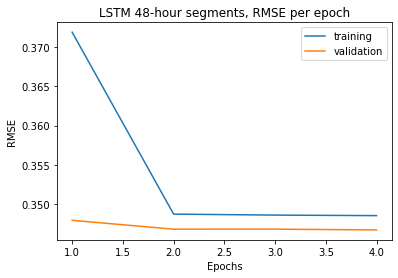

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history)+ 1), val_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['training', 'validation'])
plt.title('LSTM 48-hour segments, RMSE per epoch')
plt.show()

In [35]:
print(average_mae_history)
print(val_average_mae_history)

[0.37191564838091534, 0.34868429104487103, 0.34855883320172626, 0.34849125146865845]
[0.34789204597473145, 0.3467596669991811, 0.3467629651228587, 0.34666629632314044]


Training final model on all of the training data and evaluate on test set

In [23]:
test_data = X_test_scaled_res 
test_targets = y_test_scaled_res

In [24]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
history_test = model.fit(train_data, train_targets,
                        epochs=12, batch_size=16, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/12
1179/1179 [==============================] - 2737s 2s/step - loss: 0.1409 - root_mean_squared_error: 0.3746
Epoch 2/12
1179/1179 [==============================] - 2868s 2s/step - loss: 0.1187 - root_mean_squared_error: 0.3445
Epoch 3/12
1179/1179 [==============================] - 2700s 2s/step - loss: 0.1218 - root_mean_squared_error: 0.3490
Epoch 4/12
1179/1179 [==============================] - 2696s 2s/step - loss: 0.1205 - root_mean_squared_error: 0.3472
Epoch 5/12
1179/1179 [==============================] - 2692s 2s/step - loss: 0.1184 - root_mean_squared_error: 0.3441
Epoch 6/12
1179/1179 [==============================] - 2832s 2s/step - loss: 0.1200 - root_mean_squared_error: 0.3465
Epoch 7/12
1179/1179 [==============================] - 2838s 2s/step - loss: 0.1213 - root_mean_squared_error: 0.3482
Epoch 8/12
1179/1179 [==============================] - 2950s 3s/step - loss: 0.1201 - root_mean_squared_error: 0.3466
Epoch 9/12
1179/1179 [==========================

In [27]:
print("Average Mean Squared Error:\n")
print(test_mse_score)
print()
print("Average Root Mean Squared Error:\n")
print(test_mae_score)

Average Mean Squared Error:

0.12241896241903305

Average Root Mean Squared Error:

0.3498842120170593


In [28]:
model_48h_predict = model.predict(X_test_scaled_res, verbose = 1)
model_48h_predict = sc.inverse_transform(model_48h_predict)
print(model_48h_predict)
y_test_inversed = (sc.inverse_transform(y_test_scaled))

148/148 [==============================] - 76s 489ms/step
[[6.98638  ]
 [6.9863796]
 [6.985595 ]
 ...
 [5.0350165]
 [5.6827755]
 [6.336463 ]]


In [29]:
y_actual = y_test_inversed
y_predicted = model_48h_predict
 
MSE = mean_squared_error(y_actual, y_predicted)

#print(mean_absolute_error(y_actual, y_predicted))
print("Mean Squared Error:\n")
print(MSE)
print()
RMSE = math.sqrt(MSE)
print("Root Mean Squared Error:\n")
print(RMSE)

Mean Squared Error:

95.97647

Root Mean Squared Error:

9.796758185607402
